In [1]:
import os
import sys
sys.path.append("/home/computing/anaconda3/xyzzz/Task1/models")

import time
import pickle
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp import optimization
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel


2024-03-29 19:00:38.028103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 19:00:38.119266: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 19:00:38.142288: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 19:00:38.531673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:

# Class for loading image and text data


class ITM_DataLoader():
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    SENTENCE_EMBEDDING_SHAPE = (384)
    max_sentence_length = 300
    AUTOTUNE = tf.data.AUTOTUNE
    IMAGES_PATH = "./flickr8k-resised"
    train_data_file = "./flickr8k.TrainImages.txt"
    dev_data_file = "./flickr8k.DevImages.txt"
    test_data_file = "./flickr8k.TestImages.txt"
    sentence_embeddings_file = "./flickr8k.cmp9137.sentence_transformers.pkl"
    sentence_embeddings = {}
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.sentence_embeddings = self.load_sentence_embeddings()
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("done loading data...")

    # Sentence embeddings are dense vectors representing text data, one vector per sentence.
    # Sentences with similar vectors would mean sentences with equivalent meanning.
        # They are useful here to provide text-based features of questions in the data.
    # Note: sentence embeddings don't include label info, they are solely based on captions.
    def load_sentence_embeddings(self):
        sentence_embeddings = {}
        print("READING sentence embeddings...")
        with open(self.sentence_embeddings_file, 'rb') as f:
            data = pickle.load(f)
            for sentence, dense_vector in data.items():
                # print("*sentence=",sentence)
                sentence_embeddings[sentence] = dense_vector
        print("Done reading sentence_embeddings!")
        return sentence_embeddings

    def padded_tensor(self, unpadded_tensor):
        # max_length = 250max(len(tensor[0]) for tensor in unpadded_tensor)
        print(self.max_sentence_length)
        padded = []
        for tensor in unpadded_tensor:
            padding_length = self.max_sentence_length - len(tensor[0])
            padded_tensor = tf.pad(tensor[0], paddings=[[0, padding_length]], constant_values=0)
            reshaped_tensor = tf.reshape(padded_tensor, (1, self.max_sentence_length))
            padded.append(reshaped_tensor)

        return padded

    # In contrast to text-data based on pre-trained features, image data does not use
    # any form of pre-training in this program. Instead, it makes use of raw pixels.
    # Notes that input features to the classifier are only pixels and sentence embeddings.
    def process_input(self, img_path, text, label, text_input_ids, text_attention_mask):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255
        # print('text', text)
        # print('img_path', img_path)
        # print('bert_input_ids', bert_input_ids)
        # print('bert_attention_mask', bert_attention_mask)
        features = {}
        features["image_input"] = img
        features["text_input_ids"] = text_input_ids[0]
        features['text_attention_mask'] = text_attention_mask[0]
        features["caption"] = text
        features["file_name"] = img_path
        return features, label

    # This method loads the multimodal data, which comes from the following sources:
    # (1) image files in IMAGES_PATH, and (2) files with pattern flickr8k.*Images.txt
    # The data is stored in a tensorflow data structure to make it easy to use by
    # the tensorflow model during training, validation and test. This method was
    # carefully prepared to load the data rapidly, i.e., by loading already created
    # sentence embeddings (text features) rather than creating them at runtime.
    def load_classifier_data(self, data_files):
        print("LOADING data from "+str(data_files))
        print("=========================================")
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        image_data = []
        text_data = []
        label_data = []
        bert_input_ids = []
        bert_attention_mask = []

        # Tokenize the text data
        # get image, text, label of image_files
        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("	")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())

                # get binary labels from match/no-match answers
                label = [1, 0] if raw_label == "match" else [0, 1]
                # print("I=%s T=%s _L=%s L=%s" % (img_name, text, raw_label, label))

                # get sentence embeddings (of textual captions)
                # text_sentence_embedding = self.sentence_embeddings[text]
                # text_sentence_embedding = tf.constant(text_sentence_embedding)

                image_data.append(img_name)
                # embeddings_data.append(text_sentence_embedding)
                text_data.append(text)
                label_data.append(label)
                tokenized_texts = tokenizer(
                    text, padding=True, truncation=True, return_tensors='tf')
                bert_input_ids.append(tokenized_texts['input_ids'])
                bert_attention_mask.append(
                    tokenized_texts['attention_mask'])

        
        bert_input_ids = self.padded_tensor(bert_input_ids)
        bert_attention_mask = self.padded_tensor(bert_attention_mask)
        print("|image_data|="+str(len(image_data)), image_data[0])
        print("|text_data|="+str(len(text_data)), text_data[0])
        print("|label_data|="+str(len(label_data)), label_data[0])
        # print("|bert_input_ids|="+str(len(bert_input_ids)), bert_input_ids[0])
        # print("|bert_attention_mask|=" +
            #   str(len(bert_attention_mask)), bert_attention_mask[0])

        # prepare a tensorflow dataset using the lists generated above
        dataset = tf.data.Dataset.from_tensor_slices(
            (image_data, text_data, label_data, bert_input_ids, bert_attention_mask))
        dataset = dataset.shuffle(self.BATCH_SIZE * 8)
        dataset = dataset.map(self.process_input,
                              num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE).prefetch(self.AUTOTUNE)
        # self.print_data_samples(dataset)
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(
                    f'Sentence embeddings: {features_batch["text_embedding"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f'Label : {label}')
        print("-----------------------------------------")

range(0, 12)

In [14]:

class ITM_Classifier(ITM_DataLoader):
    epochs = 10
    learning_rate = 4e-5
    class_names = {'match', 'no-match'}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = 'ITM_Classifier-flickr'
    best_model_name = "ITM_Best_model.keras"
    best_model = None

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # return learnt feature representations of input data (images)
    def create_vision_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")
        cnn_layer = layers.Conv2D(32, 3, padding='same')(img_input)
        cnn_layer = layers.BatchNormalization()(cnn_layer)
        cnn_layer = layers.Activation("relu")(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(64, 3, padding='same')(cnn_layer)
        cnn_layer = layers.BatchNormalization()(cnn_layer)
        cnn_layer = layers.Activation("relu")(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(128, 3, padding='same')(cnn_layer)
        cnn_layer = layers.BatchNormalization()(cnn_layer)
        cnn_layer = layers.Activation("relu")(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(256, 3, padding='same')(cnn_layer)
        cnn_layer = layers.BatchNormalization()(cnn_layer)
        cnn_layer = layers.Activation("relu")(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)
        cnn_layer = layers.Flatten()(cnn_layer)
        outputs = self.project_embeddings(
            cnn_layer, num_projection_layers, projection_dims, dropout_rate)
        return img_input, outputs

    # return learnt feature representations based on dense layers, dropout, and layer normalisation
    def project_embeddings(self, embeddings, num_projection_layers, projection_dims, dropout_rate):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.relu(projected_embeddings)
            x = layers.Dense(projection_dims, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)
            # x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # return learnt feature representations of input data (text embeddings in the form of dense vectors)
    def create_text_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        for layer in bert_model.layers:
            layer.trainable = False

        max_sequence_length = 300
        text_input_ids = tf.keras.Input(
            shape=(max_sequence_length,), dtype=tf.int32, name='text_input_ids')
        text_attention_mask = tf.keras.Input(
            shape=(max_sequence_length,), dtype=tf.int32, name='text_attention_mask')
        text_output = bert_model(
            text_input_ids, attention_mask=text_attention_mask)
        # Extract hidden states as features
        text_features = text_output.last_hidden_state
        text_features = tf.keras.layers.GlobalAveragePooling1D()(text_features)
        text_features = self.project_embeddings(
            text_features, num_projection_layers, projection_dims, dropout_rate)
        return text_input_ids, text_attention_mask, text_features  # ,tokenizer
        text_input = keras.Input(
            shape=self.SENTENCE_EMBEDDING_SHAPE, name='text_embedding')
        outputs = self.project_embeddings(
            text_input, num_projection_layers, projection_dims, dropout_rate)
        return text_input, outputs

    # put together the feature representations above to create the image-text (multimodal) deep learning model
    def build_classifier_model(self):
        print(f'BUILDING model')
        img_input, vision_net = self.create_vision_encoder(
            num_projection_layers=1, projection_dims=512, dropout_rate=0.1)
        
        text_input_ids, text_attention_mask, text_net = self.create_text_encoder(
            num_projection_layers=2, projection_dims=512, dropout_rate=0.1)
        net = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        net = tf.keras.layers.Dropout(0.1)(net)

        combined_features = tf.keras.layers.Dense(512, activation='relu')(net)
        combined_features = tf.keras.layers.LayerNormalization()(combined_features)
        combined_features = tf.keras.layers.Dropout(0.1)(combined_features)        
        combined_features = tf.keras.layers.Dense(512, activation='relu')(combined_features)
        combined_features = tf.keras.layers.LayerNormalization()(combined_features)
        combined_features = tf.keras.layers.Dropout(0.1)(combined_features)
        # combined_features = tf.keras.layers.Dense(512, activation='relu')(combined_features)
        # combined_features = tf.keras.layers.LayerNormalization()(combined_features)
        # net = tf.keras.layers.Dropout(0.1)(combined_features)

        # net = tf.keras.layers.Dense(512, activation='relu')(net)
        # net = tf.keras.layers.Dropout(0.1)(net)
        # net = tf.keras.layers.Dense(512, activation='relu')(net)
        # net = tf.keras.layers.Dropout(0.1)(net)

        net = tf.keras.layers.Dense(
            self.num_classes, activation='softmax', name=self.classifier_model_name)(net)

        self.classifier_model = tf.keras.Model(
            inputs=[img_input, text_input_ids, text_attention_mask], outputs=net)
        self.classifier_model.summary()

    def train_classifier_model(self):
        print(f'TRAINING model')
        steps_per_epoch = tf.data.experimental.cardinality(
            self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2*num_train_steps)

        loss = tf.keras.losses.KLDivergence()
        metrics = tf.keras.metrics.BinaryAccuracy()
        optimizer = optimization.create_optimizer(init_lr=self.learning_rate,
                                                  num_train_steps=num_train_steps,
                                                  num_warmup_steps=num_warmup_steps,
                                                  optimizer_type='adamw')

        self.classifier_model.compile(
            optimizer=optimizer, loss=loss, metrics=metrics)
        print(self.classifier_model.summary())

        # uncomment the next line if you wish to make use of early stopping during training
        # callbacks = [tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]
        # callbacks = [tf.keras.callbacks.ModelCheckpoint(self.best_model_name, save_best_only=True)]

        self.history = self.classifier_model.fit(
            x=self.train_ds, validation_data=self.val_ds, epochs=self.epochs, batch_size=128)  # , callbacks=callbacks)
        print("model trained!")

    def test_classifier_model(self):
        # self.best_model =  tf.keras.models.load_model(self.best_model_name)
        print("TESTING classifier model (showing a sample of image-text-matching predictions)...")
        num_classifications = 0
        num_correct_predictions = 0

        # read test data for ITM classification
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            # predictions = self.best_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # read test data per batch
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                if str(groundtruth[batch_index]) == predicted_class:
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print("ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s" %
                          (caption, probability_match, probability_nomatch, file_name))

        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions/num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        # loss, accuracy = self.best_model.evaluate(self.test_ds)
        print(f'Tensorflow test method: Loss: {loss}; ACCURACY: {accuracy}')

In [15]:
itm = ITM_Classifier()

READING sentence embeddings...
Done reading sentence_embeddings!
LOADING data from ./flickr8k.TrainImages.txt
300
300
|image_data|=19386 ./flickr8k-resised/1001773457_577c3a7d70.jpg
|text_data|=19386 A black dog and a spotted dog are fighting
|label_data|=19386 [1, 0]
LOADING data from ./flickr8k.DevImages.txt
300
300
|image_data|=1164 ./flickr8k-resised/103205630_682ca7285b.jpg
|text_data|=1164 two men setting up a blue ice fishing hut on an iced over lake
|label_data|=1164 [1, 0]
LOADING data from ./flickr8k.TestImages.txt
300
300
|image_data|=1161 ./flickr8k-resised/101669240_b2d3e7f17b.jpg
|text_data|=1161 A skier looks at framed pictures in the snow next to trees .
|label_data|=1161 [1, 0]
done loading data...
BUILDING model


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 224, 224, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 224, 224, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                           

15 15


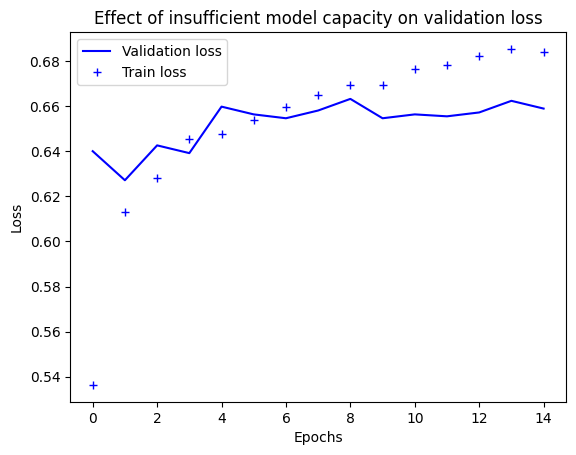

In [ ]:
import matplotlib.pyplot as plt
val_loss = itm.history.history['val_binary_accuracy']
train_loss = itm.history.history['binary_accuracy']
print(itm.epochs, len(val_loss))

epochs = range(0, itm.epochs)
plt.plot(epochs, val_loss, "b",
         label="Validation loss")
plt.plot(epochs, train_loss, "b+",
         label="Train loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


In [ ]:
keras.utils.plot_model(itm.classifier_model,'img_name.png',show_shapes=True)

NameError: name 'itm' is not defined

In [ ]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.
